In [1]:
import os
import numpy as np
from osgeo import gdal
from tqdm import tqdm  # 添加进度条
from langchain.tools import Tool
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI


In [2]:
def compute_slope_horn(tiff_path: str, output_tiff_path: str = None) -> str:
    dataset = gdal.Open(tiff_path)
    if dataset is None:
        return "❌ 无法打开 TIFF 文件"

    band = dataset.GetRasterBand(1)
    data = band.ReadAsArray().astype(np.float64)

    nodata = band.GetNoDataValue()
    if nodata is not None:
        data[data == nodata] = np.nan

    rows, cols = data.shape
    slope = np.full_like(data, np.nan)

    # 使用 tqdm 显示行处理进度
    for i in tqdm(range(1, rows - 1), desc="🛠️ 正在估算坡度"):
        for j in range(1, cols - 1):
            window = data[i-1:i+2, j-1:j+2]
            if np.isnan(window).any():
                continue

            dzdx = ((window[0, 2] + 2*window[1, 2] + window[2, 2]) - 
                    (window[0, 0] + 2*window[1, 0] + window[2, 0])) / 8
            dzdy = ((window[2, 0] + 2*window[2, 1] + window[2, 2]) - 
                    (window[0, 0] + 2*window[0, 1] + window[0, 2])) / 8

            slope[i, j] = np.sqrt(dzdx**2 + dzdy**2)

    if output_tiff_path is None:
        output_tiff_path = tiff_path.replace(".tif", "_Slope_Horn.tif")

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(output_tiff_path, cols, rows, 1, gdal.GDT_Float32)
    out_ds.SetGeoTransform(dataset.GetGeoTransform())
    out_ds.SetProjection(dataset.GetProjection())
    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(slope)
    out_band.SetNoDataValue(np.nan)
    out_ds.FlushCache()
    out_ds = None

    return f"✅ Horn 坡度计算完成，已保存为：{output_tiff_path}"


In [3]:
slope_horn_tool = Tool(
    name="Compute_Slope_Horn",
    func=lambda x: compute_slope_horn(*x.split(", ") if ", " in x else (x,)),
    description="使用 Horn 算法计算坡度，输入格式：<TIFF路径>, <输出TIFF路径（可选）>"
)

llm = ChatOpenAI(
    openai_api_key="sk-45f1d096fb524f1ca2918bd99141b7d3",
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=512,
    temperature=0,
    streaming=False
)

agent = initialize_agent(
    tools=[slope_horn_tool],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)


C:\Users\wyb04\AppData\Local\Temp\ipykernel_23280\3555069884.py:7: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
C:\Users\wyb04\AppData\Local\Temp\ipykernel_23280\3555069884.py:16: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/d

In [4]:
import os
from glob import glob
from tqdm import tqdm
import time

def wait_until_readable(path, max_retries=3, interval=1.0):
    for attempt in range(max_retries):
        try:
            ds = gdal.Open(path)
            if ds is not None:
                return True
        except:
            pass
        print(f"⏳ 第 {attempt+1} 次等待中：{path}")
        time.sleep(interval)
    return False

# 输入输出路径
input_dir = r"E:\\Mars\\raw_data\\split_10x10"
output_dir = r"E:\\Mars\\output\\slope"
os.makedirs(output_dir, exist_ok=True)

# 获取所有 DEM 子图路径
tif_files = sorted(glob(os.path.join(input_dir, "block_*.tif")))

# 批量使用 Agent 控制工具进行坡度计算
for tif_path in tqdm(tif_files, desc="Processing DEM Tiles"):
    if not wait_until_readable(tif_path, max_retries=5):
        print(f"❌ 文件无法打开，跳过：{tif_path}")
        continue

    filename = os.path.basename(tif_path).replace(".tif", "")
    output_path = os.path.join(output_dir, f"{filename}_Slope_Horn.tif")

    # 已存在则跳过（可选）
    if os.path.exists(output_path):
        print(f"✅ 已存在：{output_path}，跳过")
        continue

    # 大模型指令
    prompt = (
        f"请使用 Horn 算法计算坡度：输入路径为 \"{tif_path}\"，"
        f"将结果保存为 \"{output_path}\"，仅使用 Compute_Slope_Horn 工具。"
    )

    try:
        response = agent.run(prompt)
        print(f"✅ 完成: {filename} → {response}")
    except Exception as e:
        print(f"❌ 错误: {filename} → {e}")


Processing DEM Tiles: 0it [00:00, ?it/s]


In [5]:
#测试有没有保留图片基本地理信息
from osgeo import gdal

ds = gdal.Open(r"E:\Mars\output\slope\block_3_7_Slope_Horn.tif")
print("GeoTransform:", ds.GetGeoTransform())  # 地理左上角 + 分辨率
print("Projection:", ds.GetProjection())      # 投影信息


GeoTransform: (30842.353800000623, 3.5, 0.0, 1496689.214622274, 0.0, -3.5)
Projection: PROJCS["SimpleCylindrical_Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",110],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


#进行大图拼接
import os
from glob import glob
from osgeo import gdal

input_dir = r"E:\Mars\output\slope"
output_path = r"E:\Mars\output\merged_slope_horn.tif"

tif_files = sorted(glob(os.path.join(input_dir, "*_Slope_Horn.tif")))

gdal.Warp(
    destNameOrDestDS=output_path,
    srcDSOrSrcDSTab=tif_files,
    format='GTiff',
    options=gdal.WarpOptions(
        format='GTiff',
        resampleAlg='near',
        multithread=True,
        dstNodata=float('nan')
    )
)

print(f"✅ 拼接完成，输出路径为：{output_path}")


In [6]:
import os
import csv  # ✅ 加上这行
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import rasterio
from rasterio.plot import show
from scipy.ndimage import label
from skimage import measure

# 中文显示支持
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False


In [7]:
import csv  # ✅ 必须添加，避免 NameError

def extract_and_plot_landing_zones(tif_path: str, slope_threshold: float = 10.0) -> str:
    try:
        slope_threshold = float(slope_threshold)
        max_area_px = 10000  # ✅ 设置最大像素面积阈值

        with rasterio.open(tif_path) as src:
            slope_array = src.read(1).astype(np.float32)
            slope_array = np.where(slope_array == src.nodata, np.nan, slope_array)
            transform = src.transform

        mask = (slope_array < slope_threshold) & ~np.isnan(slope_array)
        labeled_array, num_features = label(mask)
        contours = measure.find_contours(labeled_array, level=0.5)
        props = measure.regionprops(labeled_array)

        pixel_area = abs(transform[0] * transform[4])

        # 🎨 彩色坡度图
        output_colormap = tif_path.replace(".tif", "_Slope_ColorMap.png")
        plt.figure(figsize=(8, 12))
        img = plt.imshow(slope_array, cmap='viridis', vmin=0, vmax=20)
        plt.colorbar(img, label="坡度")
        plt.title("彩色坡度图")
        plt.axis("off")
        plt.savefig(output_colormap, bbox_inches='tight')
        plt.close()

        # 📊 输出统计信息 CSV（已筛除大面积区域）
        output_csv = tif_path.replace(".tif", "_Landing_Zone_Stats.csv")
        filtered_props = []
        height, width = slope_array.shape
        margin = 10

        for i, prop in enumerate(props):
            cy, cx = prop.centroid
            area_px = prop.area
            area_m2 = area_px * pixel_area

            if (
                cx < margin or cx > width - margin or
                cy < margin or cy > height - margin or
                area_px > max_area_px
            ):
                continue

            filtered_props.append((i + 1, cx, cy, area_px, area_m2))

        indexed_props = sorted(filtered_props, key=lambda x: (x[2], x[1]))  # 按 y 上到下，x 左到右排序

        with open(output_csv, "w", newline="", encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["区域序号", "中心横坐标", "中心纵坐标", "面积 (像素)", "面积 (平方米)"])
            for row in indexed_props:
                writer.writerow(row)

        # 🖼️ 着陆区圈图（彩色 + 红线 + 编号）
        output_mask = tif_path.replace(".tif", f"_Landing_Zones_{slope_threshold}_ColorOverlay.png")
        plt.figure(figsize=(10, 10))
        plt.imshow(slope_array, cmap='viridis', vmin=0, vmax=20)
        plt.colorbar(label="坡度")

        for i, contour in enumerate(tqdm(contours, desc="🚀 绘制着陆边界")):
            y = contour[:, 0]
            x = contour[:, 1]
            if (
                (np.ptp(x) < 3 or np.ptp(y) < 3) and
                (
                    np.min(x) < margin or np.max(x) > width - margin or
                    np.min(y) < margin or np.max(y) > height - margin
                )
            ):
                continue
            plt.plot(x, y, color='red', linewidth=1.2)

        for idx, cx, cy, area, sqm in indexed_props:
            plt.text(cx, cy, str(idx), color='white', fontsize=8, ha='center', va='center',
                     bbox=dict(facecolor='black', alpha=0.4, boxstyle='round'))

        plt.title(f"坡度 < {slope_threshold:.1f}° 着陆区（共 {len(indexed_props)} 个）")
        plt.axis('off')
        plt.savefig(output_mask, bbox_inches='tight', dpi=300)
        plt.close()

        return f"""✅ 圈选完成：
📊 彩色坡度图：{output_colormap}
🖼️ 着陆区图：{output_mask}
📄 数据表格：{output_csv}
共识别区域数量：{len(indexed_props)} 个"""

    except Exception as e:
        return f"❌ 圈选失败：{e}"


# ✅ 注册为工具
landing_zone_tool = Tool(
    name="Select_Landing_Zones",
    func=lambda x: extract_and_plot_landing_zones(*x.split(", ") if ", " in x else (x,)),
    description="根据坡度阈值自动圈选着陆区，输入格式：<TIFF路径>, <坡度阈值（可选，默认7）>"
)

# ✅ 初始化 Agent（使用 DashScope 接入通义千问）
llm = ChatOpenAI(
    openai_api_key="sk-45f1d096fb524f1ca2918bd99141b7d3",
    openai_api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name="qwen-max",
    max_tokens=512,
    temperature=0,
    streaming=False
)

agent = initialize_agent(
    tools=[landing_zone_tool],
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    allow_dangerous_code=True
)


In [8]:
prompt = (
    "请使用 Select_Landing_Zones 工具圈选坡度图 E:/Mars/output/merged_slope_horn.tif，"
    "设定阈值为7.0度。"
)
response = agent.run(prompt)
print(response)

C:\Users\wyb04\AppData\Local\Temp\ipykernel_23280\3612738738.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run(prompt)




> Entering new AgentExecutor chain...


KeyboardInterrupt: 

In [9]:
#着陆区排序
import csv

input_csv = r"E:\Mars\output\merged_slope_horn_Landing_Zone_Stats.csv"
output_csv = r"E:\Mars\output\result.csv"

with open(input_csv, newline='', encoding='gbk') as f:
    reader = csv.reader(f)
    header = next(reader)
    rows = list(reader)

# 找到“面积 (平方米)”这一列的索引
area_idx = header.index("面积 (平方米)")

# 按面积（平方米）降序排序
rows_sorted = sorted(rows, key=lambda x: float(x[area_idx]), reverse=True)

with open(output_csv, "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows_sorted)

print(f"✅ 排序完成，结果已保存为：{output_csv}")

✅ 排序完成，结果已保存为：E:\Mars\output\result.csv


读取 TIFF 文件成功


KeyboardInterrupt: 

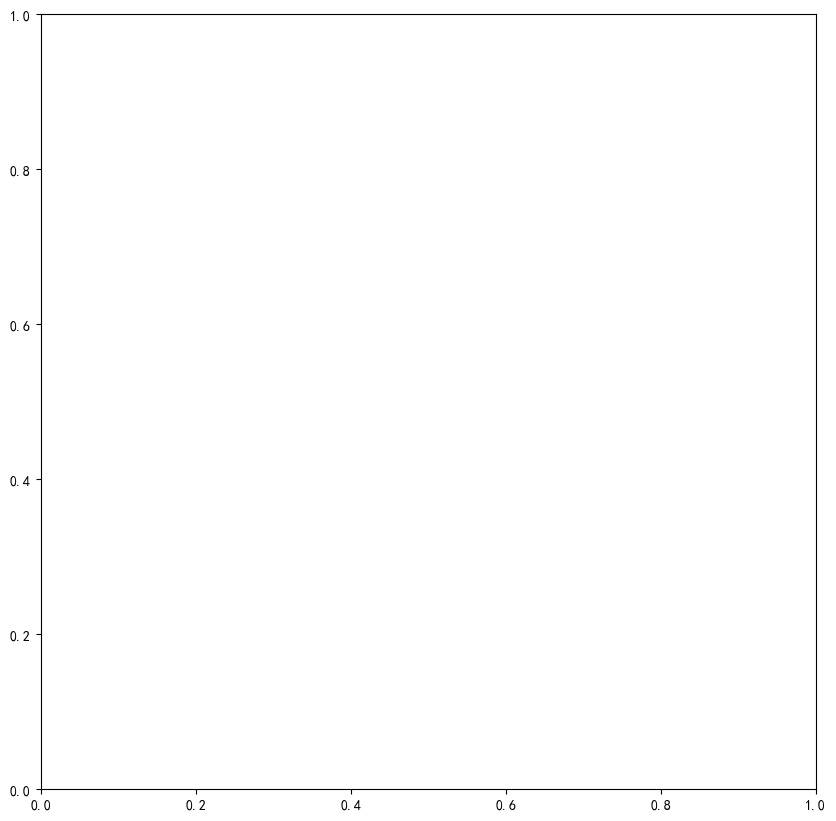

In [10]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt

# 👉 文件路径
tif_path = r"E:\Mars\output\merged_slope_horn.tif"
csv_path = r"E:\Mars\output\result.csv" 

# ✅ 读取 CSV（尝试兼容编码）
df = pd.read_csv(csv_path, encoding='utf-8')

# ✅ 获取面积最大的前 10 个区域
top10 = df.sort_values(by="面积 (像素)", ascending=False).head(10)

# ✅ 打开 TIFF 文件作为背景图
with rasterio.open(tif_path) as src:
    slope = src.read(1)
    transform = src.transform
print("读取 TIFF 文件成功")
# ✅ 可视化
plt.figure(figsize=(10, 12))
plt.imshow(slope, cmap='viridis', vmin=0, vmax=20)
plt.colorbar(label="坡度")
plt.title("坡度图 + 前10着陆区中心")

# 🔴 绘制中心点 + 编号
for i, row in top10.iterrows():
    x = row["中心横坐标"]
    y = row["中心纵坐标"]
    plt.plot(x, y, marker='o', color='red', markersize=6)
    plt.text(x, y, str(int(row["区域序号"])), color='white', fontsize=8,
             ha='center', va='center',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))

plt.axis('off')
plt.savefig(tif_path.replace(".tif", "_Top10_Center_Marked.png"), bbox_inches='tight', dpi=300)
plt.show()
